### Unzip files

In [1]:
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/7bc54bf1a7e9988f2b7ad70eae9200a0.jpg  
  inflating: train/7bdb88b4e816d3094c8b3b5b2386e436.jpg  
  inflating: train/7bed9596047ca6452e723a22dc1215a6.jpg  
  inflating: train/7c3556d5bbd3f96ee71597b635e2d179.jpg  
  inflating: train/7c613074e1725da55956fc58a10a128b.jpg  
  inflating: train/7d7e1d15aaa88da898118e58873a3ce6.jpg  
  inflating: train/7da5d475a405821afd70635a87e35564.jpg  
  inflating: train/7db4391b63c19ff29e57323cf3b226eb.jpg  
  inflating: train/7dcc67717f845e692ea9e793ed807964.jpg  
  inflating: train/7dd0044c023e31c204c5b4e2d483d4da.jpg  
  inflating: train/7e12e683356111f3778f8fdfd13a4f89.jpg  
  inflating: train/7e2378b48432821bcdaea804a56bc5ce.jpg  
  inflating: train/7e43991fe09943006c8313417d9e8d14.jpg  
  inflating: train/7ee9407aa335dfa4bb65ebbeef5c029b.jpg  
  inflating: train/7f34c065bd90f8d96a361606aafa1679.jpg  
  inflating: train/7f7c0c10ea0286b9fd8861f3ef36bda0.jpg  
  inflating: train/7f

### Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

### Load dataset

In [3]:
train_csv = pd.read_csv('train.csv')
train_csv.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
train_csv.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


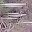

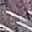

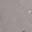

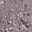

In [5]:
# Image that has cactus
display(Image('train/0004be2cfeaba1c0361d39e2b000257b.jpg'))
display(Image('train/000c8a36845c0208e833c79c1bffedd1.jpg'))

# Image that has no cactus
display(Image('train/ffede47a74e47a5930f81c0b6896479e.jpg'))
display(Image('train/fff43acb3b7a23edcc4ae937be2b7522.jpg'))

In [26]:
filenames = ['train/' + fname for fname in train_csv['id'].tolist()]
labels = train_csv['has_cactus'].tolist()

train_filenames, remaining_filenames, train_labels, remaining_labels = train_test_split(filenames, labels, train_size = 0.8, random_state = 420)
val_filenames, test_filenames, val_labels, test_labels = train_test_split(filenames, labels, train_size = 0.5, random_state = 420)

num_train = len(train_filenames)

In [7]:
IMAGE_SIZE = 96

def parse_filename(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32) / 127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [8]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(parse_filename).shuffle(buffer_size = 10000).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(parse_filename).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_filenames), tf.constant(test_labels))).map(parse_filename).shuffle(buffer_size = 10000).batch(BATCH_SIZE)


### Define base model

In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')

In [11]:
learning_rate = 0.0001

model = tf.keras.Sequential([base_model, maxpool_layer, prediction_layer])
model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


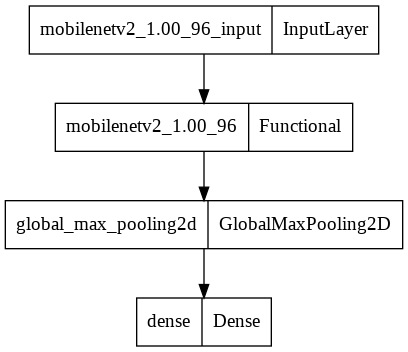

In [12]:
tf.keras.utils.plot_model(model)

### Train the model

In [13]:
num_epochs = 30
steps_per_epoch = round(num_train) // BATCH_SIZE
val_steps = 20

In [14]:
history = model.fit(train_data.repeat(), epochs = num_epochs, steps_per_epoch = steps_per_epoch, validation_data = val_data.repeat(), validation_steps = val_steps)

Epoch 1/30
437/437 [==============================] - 31s 36ms/step - loss: 0.2999 - accuracy: 0.8726 - val_loss: 0.1497 - val_accuracy: 0.9469
Epoch 2/30
437/437 [==============================] - 17s 39ms/step - loss: 0.1023 - accuracy: 0.9655 - val_loss: 0.1041 - val_accuracy: 0.9609
Epoch 3/30
437/437 [==============================] - 17s 38ms/step - loss: 0.0752 - accuracy: 0.9745 - val_loss: 0.0822 - val_accuracy: 0.9641
Epoch 4/30
437/437 [==============================] - 18s 41ms/step - loss: 0.0616 - accuracy: 0.9792 - val_loss: 0.0713 - val_accuracy: 0.9750
Epoch 5/30
437/437 [==============================] - 17s 40ms/step - loss: 0.0537 - accuracy: 0.9814 - val_loss: 0.0611 - val_accuracy: 0.9766
Epoch 6/30
437/437 [==============================] - 17s 38ms/step - loss: 0.0478 - accuracy: 0.9841 - val_loss: 0.0551 - val_accuracy: 0.9781
Epoch 7/30
437/437 [==============================] - 18s 41ms/step - loss: 0.0436 - accuracy: 0.9855 - val_loss: 0.0500 - val_accuracy:

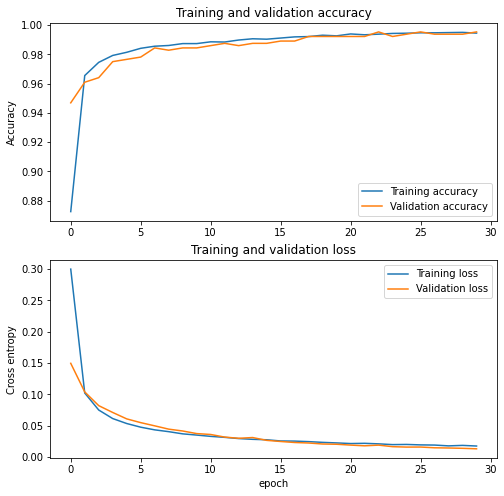

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label = 'Training accuracy')
plt.plot(val_accuracy, label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross entropy')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.show()

### Test the base model

In [16]:
print("Evaluation of base model on test data")
results = model.evaluate(test_data, batch_size = BATCH_SIZE)
print("Test loss, test accuracy:", results)

Evaluation of base model on test data
274/274 [==============================] - 10s 26ms/step - loss: 0.0256 - accuracy: 0.9920
Test loss, test accuracy: [0.0255572646856308, 0.9919999837875366]


### Fine tuning the model

In [21]:
base_model.trainable = True

for layer in base_model.layers[:100]:
  layer.trainable =  False

lr_finetune = learning_rate / 10

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = lr_finetune), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [22]:
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine_tuned  = model.fit(train_data.repeat(), steps_per_epoch = steps_per_epoch, epochs = total_epochs, initial_epoch = num_epochs, validation_data = val_data.repeat(), validation_steps = val_steps)

Epoch 31/60
437/437 [==============================] - 28s 45ms/step - loss: 0.2009 - accuracy: 0.9387 - val_loss: 0.0813 - val_accuracy: 0.9766
Epoch 32/60
437/437 [==============================] - 23s 51ms/step - loss: 0.0807 - accuracy: 0.9724 - val_loss: 0.0664 - val_accuracy: 0.9859
Epoch 33/60
437/437 [==============================] - 22s 51ms/step - loss: 0.0585 - accuracy: 0.9801 - val_loss: 0.0459 - val_accuracy: 0.9859
Epoch 34/60
437/437 [==============================] - 24s 55ms/step - loss: 0.0399 - accuracy: 0.9851 - val_loss: 0.0271 - val_accuracy: 0.9922
Epoch 35/60
437/437 [==============================] - 21s 49ms/step - loss: 0.0277 - accuracy: 0.9897 - val_loss: 0.0107 - val_accuracy: 0.9937
Epoch 36/60
437/437 [==============================] - 21s 48ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0053 - val_accuracy: 0.9984
Epoch 37/60
437/437 [==============================] - 22s 51ms/step - loss: 0.0200 - accuracy: 0.9928 - val_loss: 0.0025 - val_ac

In [23]:
accuracy = accuracy + history_fine_tuned.history['accuracy']
val_accuracy = val_accuracy + history_fine_tuned.history['val_accuracy']

loss = loss + history_fine_tuned.history['loss']
val_loss = val_loss + history_fine_tuned.history['val_loss']

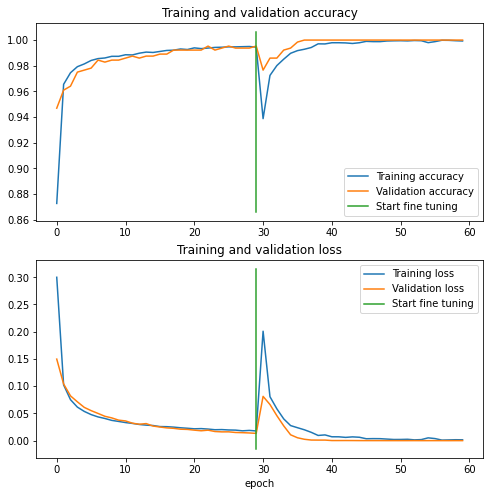

In [24]:
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label = 'Training accuracy')
plt.plot(val_accuracy, label = 'Validation accuracy')
plt.plot([num_epochs - 1,num_epochs - 1], 
          plt.ylim(), label = 'Start fine tuning')
plt.legend(loc = 'lower right')
plt.title('Training and validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.plot([num_epochs - 1,num_epochs - 1], 
         plt.ylim(), label = 'Start fine tuning')
plt.legend(loc = 'upper right')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.show()

### Test the fine-tuned model

In [25]:
print("Evaluation of fine-tuned model on test data")
results = model.evaluate(test_data, batch_size = BATCH_SIZE)
print("Test loss, test accuracy:", results)

Evaluation of fine-tuned model on test data
274/274 [==============================] - 10s 25ms/step - loss: 0.0144 - accuracy: 0.9960
Test loss, test accuracy: [0.014437632635235786, 0.9959999918937683]
